In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ccxt
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import EMAIndicator, MACD
from ta.volatility import BollingerBands, AverageTrueRange
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Step 1: Download Binance OHLCV
# ===========================
exchange = ccxt.binance({'enableRateLimit': True})
symbol = 'BTC/USDT'
timeframe = '1h'
limit = 2000  # more candles for NN

ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
df = pd.DataFrame(ohlcv, columns=['timestamp','open','high','low','close','volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
for c in ['open','high','low','close','volume']:
    df[c] = df[c].astype(float)

In [3]:
# Step 2: Compute Technical Indicators
# ===========================
df['ema_10'] = EMAIndicator(df['close'], window=10).ema_indicator()
df['ema_21'] = EMAIndicator(df['close'], window=21).ema_indicator()
df['ema_slope'] = df['ema_10'] - df['ema_21']

macd = MACD(df['close'])
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()

df['rsi'] = RSIIndicator(df['close'], window=14).rsi()
df['stoch'] = StochasticOscillator(df['high'], df['low'], df['close'], window=14).stoch()

bb = BollingerBands(df['close'], window=20, window_dev=2)
df['bb_high'] = bb.bollinger_hband()
df['bb_low'] = bb.bollinger_lband()

df['atr'] = AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
df['body'] = df['close'] - df['open']
df['range'] = df['high'] - df['low']

# Target: next candle bullish
df['target'] = (df['close'].shift(-1) > df['open'].shift(-1)).astype(int)
df.dropna(inplace=True)


In [4]:
# Step 3: Prepare Features and LSTM sequences
# ===========================
features = [
    'rsi','stoch','ema_slope','macd','macd_signal',
    'bb_high','bb_low','atr','body','range','volume'
]

X = df[features].values
y = df['target'].values

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Sequence length (look-back candles for LSTM)
SEQ_LEN = 10

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X)-seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y, SEQ_LEN)

# Train-test split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # no shuffle for time series


In [5]:
# Step 4: Build LSTM Model
# ===========================
class CandleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(CandleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last time step
        out = self.fc(out)
        return out

model = CandleLSTM(X_train.shape[2])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [10]:
# Step 5: Train Model
# ===========================
epochs = 5000
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


Epoch 5/5000, Loss: 0.4966
Epoch 10/5000, Loss: 0.4703
Epoch 15/5000, Loss: 0.4290
Epoch 20/5000, Loss: 0.4521
Epoch 25/5000, Loss: 0.3680
Epoch 30/5000, Loss: 0.3535
Epoch 35/5000, Loss: 0.3729
Epoch 40/5000, Loss: 0.3493
Epoch 45/5000, Loss: 0.2913
Epoch 50/5000, Loss: 0.2438
Epoch 55/5000, Loss: 0.2650
Epoch 60/5000, Loss: 0.2171
Epoch 65/5000, Loss: 0.3112
Epoch 70/5000, Loss: 0.1897
Epoch 75/5000, Loss: 0.1720
Epoch 80/5000, Loss: 0.1485
Epoch 85/5000, Loss: 0.1787
Epoch 90/5000, Loss: 0.1912
Epoch 95/5000, Loss: 0.1438
Epoch 100/5000, Loss: 0.1725
Epoch 105/5000, Loss: 0.1493
Epoch 110/5000, Loss: 0.1230
Epoch 115/5000, Loss: 0.1175
Epoch 120/5000, Loss: 0.1120
Epoch 125/5000, Loss: 0.0872
Epoch 130/5000, Loss: 0.0895
Epoch 135/5000, Loss: 0.1309
Epoch 140/5000, Loss: 0.0801
Epoch 145/5000, Loss: 0.0728
Epoch 150/5000, Loss: 0.0769
Epoch 155/5000, Loss: 0.0872
Epoch 160/5000, Loss: 0.1041
Epoch 165/5000, Loss: 0.0965
Epoch 170/5000, Loss: 0.0408
Epoch 175/5000, Loss: 0.1161
Epoch

In [12]:
# Step 6: Evaluate Model
# ===========================
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_t).numpy().flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy*100:.2f}%")


Test accuracy: 45.83%


In [13]:
# Step 7: Backtest Strategy
# ===========================
cash = 1000
position = 0
trades = []

for i in range(len(y_pred)):
    price = df['close'].iloc[split + SEQ_LEN + i]
    pred = y_pred[i]

    if pred == 1 and position == 0:
        position = cash / price
        cash = 0
        trades.append({"index": split+SEQ_LEN+i, "price": price, "side": "buy"})
    elif pred == 0 and position > 0:
        cash = position * price
        position = 0
        trades.append({"index": split+SEQ_LEN+i, "price": price, "side": "sell"})

if position > 0:
    cash = position * df['close'].iloc[-1]

print(f"Initial capital: $1000")
print(f"Final capital: ${cash:.2f}")
print(f"Net profit: ${cash-1000:.2f}")
print(f"Total trades executed: {len(trades)}")

Initial capital: $1000
Final capital: $973.34
Net profit: $-26.66
Total trades executed: 82


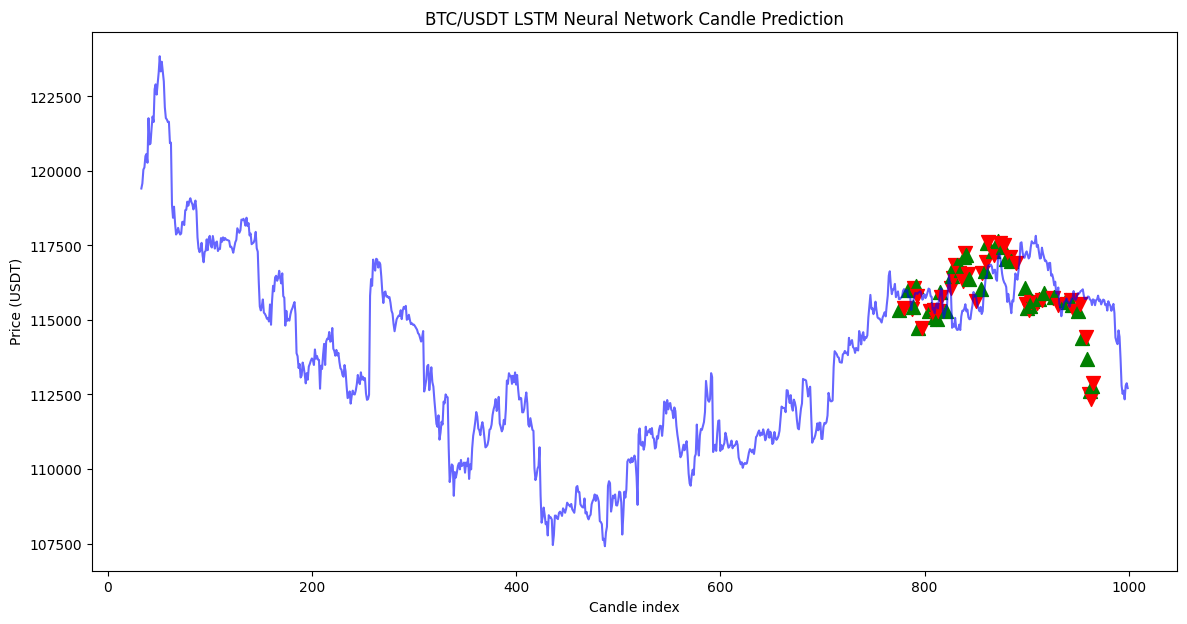

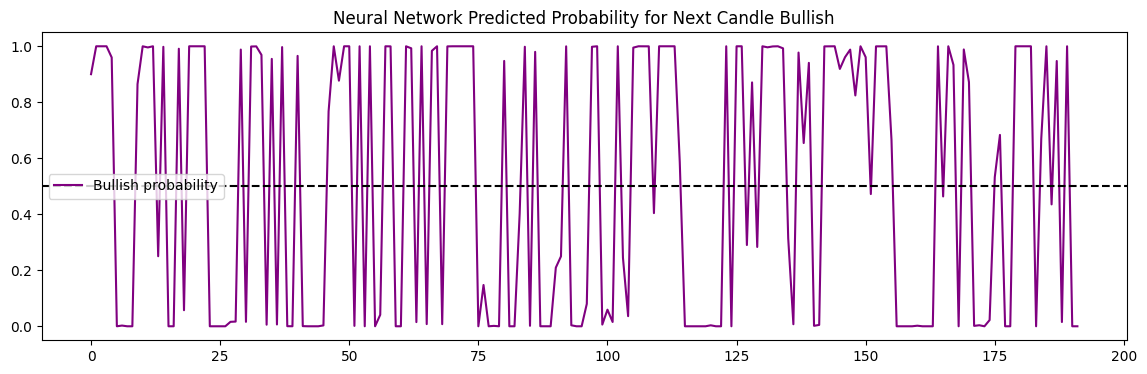

In [14]:
# Step 8: Visualization
# ===========================
plt.figure(figsize=(14,7))
plt.plot(df['close'], label='BTC/USDT Price', color='blue', alpha=0.6)
plt.title('BTC/USDT LSTM Neural Network Candle Prediction')
plt.xlabel('Candle index')
plt.ylabel('Price (USDT)')

for t in trades:
    if t['side'] == 'buy':
        plt.scatter(t['index'], t['price'], marker='^', color='green', s=100)
    elif t['side'] == 'sell':
        plt.scatter(t['index'], t['price'], marker='v', color='red', s=100)

plt.show()

plt.figure(figsize=(14,4))
plt.plot(np.arange(len(y_pred_prob)), y_pred_prob, color='purple', label='Bullish probability')
plt.axhline(0.5, color='black', linestyle='--')
plt.title('Neural Network Predicted Probability for Next Candle Bullish')
plt.legend()
plt.show()